## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
data_path = "../DATA/archive/HI-Small_Trans.csv"

## Load the raw data

In [47]:
raw_df = pd.read_csv(data_path)

raw_df.shape

(5078345, 11)

In [84]:
# import pyarrow.csv as pv
# import pyarrow.parquet as pq

# # table = pv.read_csv(data_path)
# # pq.write_table(table[4000:6000], data_path.replace('csv', 'parquet'))

# raw_df[4000:6000].to_parquet(data_path.replace('csv', 'parquet'), engine='pyarrow')

# Reading the Parquet file using pyarrow
df_123123 = pd.read_parquet('/media/volcano/SPSSD/DATA1/DUT/GRADUATION_THESIS/MLOps/mlops-code/data_pipeline/data_sources/driver_stats.parquet', engine='pyarrow')

# Display the dataframe
print(df_123123.head())

                   datetime  driver_id  conv_rate  acc_rate  avg_daily_trips  \
0 2021-07-13 11:00:00+00:00       1005   0.373837  0.154890              498   
1 2021-07-13 12:00:00+00:00       1005   0.571627  0.643958              656   
2 2021-07-13 13:00:00+00:00       1005   0.399909  0.993888              722   
3 2021-07-13 14:00:00+00:00       1005   0.967468  0.788458              424   
4 2021-07-13 15:00:00+00:00       1005   0.024679  0.956064              569   

                  created  
0 2021-07-28 11:08:04.802  
1 2021-07-28 11:08:04.802  
2 2021-07-28 11:08:04.802  
3 2021-07-28 11:08:04.802  
4 2021-07-28 11:08:04.802  


In [81]:
df_1231123 = pd.read_parquet('/media/volcano/SPSSD/DATA1/DUT/GRADUATION_THESIS/MLOps/mlops-code/data_pipeline/data_sources/HI-Small_Trans.parquet', engine='pyarrow')

# # Display the dataframe
print(df_1231123.dtypes)

Timestamp              object
From Bank               int64
Account                object
To Bank                 int64
Account.1              object
Amount Received       float64
Receiving Currency     object
Amount Paid           float64
Payment Currency       object
Payment Format         object
Is Laundering           int64
dtype: object


In [4]:
df = raw_df.sample(n=50000, random_state=1)

df.shape

(50000, 11)

In [5]:
df.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [6]:
df.head(3)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
4205263,2022/09/08 23:03,70,100428A08,148586,8120D5550,13204.53,Saudi Riyal,13204.53,Saudi Riyal,Cash,0
3270156,2022/09/07 00:15,1132,80C50E4A0,28,80B7644F0,329.94,Mexican Peso,329.94,Mexican Peso,Credit Card,0
2669041,2022/09/05 18:41,70,1004288E8,32814,80C1FC0D0,54497.52,Mexican Peso,54497.52,Mexican Peso,Credit Card,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 4205263 to 1446591
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Timestamp           50000 non-null  object 
 1   From Bank           50000 non-null  int64  
 2   Account             50000 non-null  object 
 3   To Bank             50000 non-null  int64  
 4   Account.1           50000 non-null  object 
 5   Amount Received     50000 non-null  float64
 6   Receiving Currency  50000 non-null  object 
 7   Amount Paid         50000 non-null  float64
 8   Payment Currency    50000 non-null  object 
 9   Payment Format      50000 non-null  object 
 10  Is Laundering       50000 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 4.6+ MB


In [8]:
df['From Bank'].value_counts()

From Bank
70        4352
12         794
10         789
1          585
15         548
          ... 
35764        1
315832       1
321151       1
324818       1
335948       1
Name: count, Length: 3429, dtype: int64

In [9]:
df['To Bank'].value_counts()

To Bank
12        415
10        406
15        397
220       321
1         292
         ... 
313815      1
348279      1
324448      1
329285      1
310723      1
Name: count, Length: 2135, dtype: int64

In [10]:
df[['Account', 'Account.1']].describe()

,Account,Account.1
count,50000,50000
unique,37434,44321
top,100428660,100428660
freq,1648,12


In [11]:
df['Is Laundering'].value_counts()

Is Laundering
0    49934
1       66
Name: count, dtype: int64

<Axes: xlabel='Is Laundering', ylabel='count'>

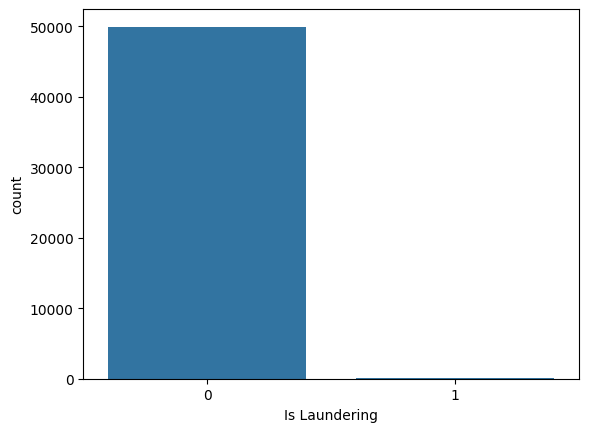

In [12]:
sns.countplot(data=df, x='Is Laundering')

In [13]:
## Dropping some columns

cols_to_drop = ['Timestamp', 'Amount Paid', 'Payment Currency']

df.drop(cols_to_drop, axis=1, inplace=True)

df.head(2)

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Payment Format,Is Laundering
4205263,70,100428A08,148586,8120D5550,13204.53,Saudi Riyal,Cash,0
3270156,1132,80C50E4A0,28,80B7644F0,329.94,Mexican Peso,Credit Card,0


In [14]:
numeric_cols = df.select_dtypes(exclude="object").columns

numeric_cols

Index(['From Bank', 'To Bank', 'Amount Received', 'Is Laundering'], dtype='object')

In [15]:
categorical_cols = df.select_dtypes(include="object").columns

categorical_cols

Index(['Account', 'Account.1', 'Receiving Currency', 'Payment Format'], dtype='object')

In [16]:
## Unique columns in df

unique_counts = df[categorical_cols].nunique()
print("Unique columns in the DataFrame: \n", unique_counts)

Unique columns in the DataFrame: 
 Account               37434
Account.1             44321
Receiving Currency       15
Payment Format            7
dtype: int64


In [17]:
df.head(3)

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Payment Format,Is Laundering
4205263,70,100428A08,148586,8120D5550,13204.53,Saudi Riyal,Cash,0
3270156,1132,80C50E4A0,28,80B7644F0,329.94,Mexican Peso,Credit Card,0
2669041,70,1004288E8,32814,80C1FC0D0,54497.52,Mexican Peso,Credit Card,0


In [18]:
df.columns

Index(['From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received',
       'Receiving Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [19]:
df['Receiving Currency'].value_counts()

Receiving Currency
US Dollar            18395
Euro                 11583
Swiss Franc           2444
Yuan                  1977
Shekel                1923
UK Pound              1819
Rupee                 1804
Yen                   1578
Ruble                 1564
Bitcoin               1483
Australian Dollar     1401
Canadian Dollar       1342
Mexican Peso          1110
Saudi Riyal            860
Brazil Real            717
Name: count, dtype: int64

In [20]:
df.isnull().sum()

From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Payment Format        0
Is Laundering         0
dtype: int64

## Dividing into Independent and Dependent features

In [21]:
X = df.drop(columns=["Is Laundering"], axis=1)
y = df["Is Laundering"]

In [22]:
numerical_features = X.select_dtypes(exclude="object").columns

numerical_features

Index(['From Bank', 'To Bank', 'Amount Received'], dtype='object')

In [23]:
categorical_features = X.select_dtypes(include="object").columns

categorical_features

Index(['Account', 'Account.1', 'Receiving Currency', 'Payment Format'], dtype='object')

## Defining the Pipeline

In [24]:
## Define the pipeline

num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinalencoder", OrdinalEncoder()),
    ]
)

In [25]:
transformer = ColumnTransformer(transformers=[
    ("OrdinalEncoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
    ("RobustScaler", RobustScaler(), numerical_features)
], remainder="passthrough")

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [28]:
X_train.shape, X_test.shape

((40000, 7), (10000, 7))

## Training Base Model

In [29]:
param_grid = {
    'max_depth': [4,8,16],
    'eta': [0.1,0.2,0.3],
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=2,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred)
print("Test AUC: ", test_auc)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END ...............................eta=0.1, max_depth=4; total time=   1.1s


[CV] END ...............................eta=0.1, max_depth=4; total time=   1.7s
[CV] END ...............................eta=0.1, max_depth=8; total time=   0.2s
[CV] END ...............................eta=0.1, max_depth=8; total time=   0.4s
[CV] END ..............................eta=0.1, max_depth=16; total time=   0.7s
[CV] END ..............................eta=0.1, max_depth=16; total time=   0.4s
[CV] END ...............................eta=0.2, max_depth=4; total time=   0.2s
[CV] END ...............................eta=0.2, max_depth=4; total time=   0.2s
[CV] END ...............................eta=0.2, max_depth=8; total time=   3.1s
[CV] END ...............................eta=0.2, max_depth=8; total time=   0.2s
[CV] END ..............................eta=0.2, max_depth=16; total time=   0.2s
[CV] END ..............................eta=0.2, max_depth=16; total time=   1.3s
[CV] END ...............................eta=0.3, max_depth=4; total time=   1.2s
[CV] END ...................

Test Set AUC:  0.9215938027524249


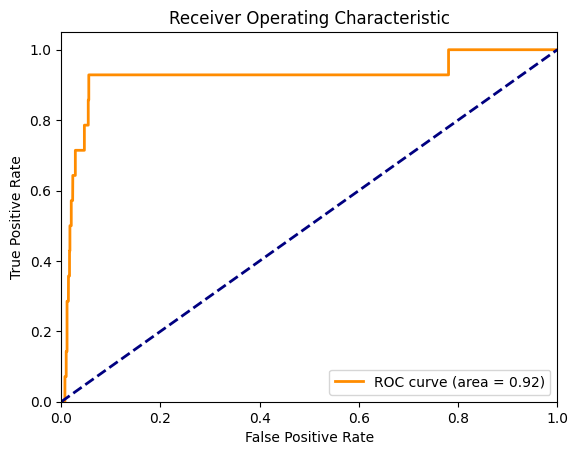

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

test_probabilities = best_model.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, test_probabilities)
print("Test Set AUC: ", test_auc)

fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show();

Desired TPR of around 90%:


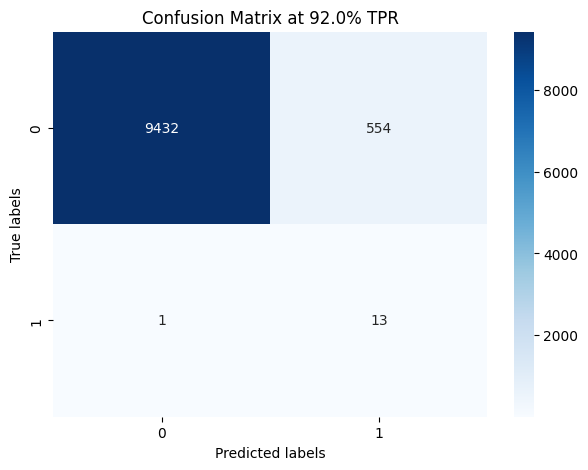

False Positive Rate (FPR): 0.055
True Positive Rate (TPR): 0.929


In [31]:
# Confusion Matrix, TPR, and FPR at around a TPR of 0.87
desired_tpr = 0.92
closest_threshold = thresholds[np.argmin(np.abs(tpr - desired_tpr))]
print(f"Desired TPR of around 90%:")

y_pred = (test_probabilities >= closest_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix at {desired_tpr*100}% TPR')
plt.show()

tn, fp, fn, tp = cm.ravel()
fpr_cm = fp / (fp + tn)
tpr_cm = tp / (tp + fn)

print(f"False Positive Rate (FPR): {fpr_cm:.3f}")
print(f"True Positive Rate (TPR): {tpr_cm:.3f}")

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      9986
           1       0.02      0.93      0.04        14

    accuracy                           0.94     10000
   macro avg       0.51      0.94      0.51     10000
weighted avg       1.00      0.94      0.97     10000



## Handling Data Imbalance using SMOTE

In [33]:
# upsampling using smote
# upsampling using smote

from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train_os)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", X_train_os.shape, y_train_os.shape)

Class= 0, n=39948 (99.87%)
Class= 1, n=52 (0.13%)
Class= 0, n=39948 (99.87%)
Class= 1, n=39948 (99.87%)
Upsampled data shape:  (79896, 7) (79896,)


In [34]:
from collections import Counter

# Assuming 'y' is your target variable
class_distribution = Counter(y_train_os)

# Print the class distribution
for class_label, count in class_distribution.items():
    print(f"Class {class_label}: {count} samples")

# Check if 'y' is balanced
is_balanced = all(count == class_distribution[y_train_os[0]] for count in class_distribution.values())

if is_balanced:
    print("The target variable 'y' is balanced.")
else:
    print("The target variable 'y' is imbalanced.")

Class 0: 39948 samples
Class 1: 39948 samples
The target variable 'y' is balanced.


In [35]:
def fit_classification_models(X, y, test_size=0.2, random_state=42):
    """
    Fit classification models using XGBoost, RandomForest, and ExtraTrees classifiers.

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        The input data.

    y : array-like of shape (n_samples,)
        The target variable.

    test_size : float, default=0.2
        The proportion of the dataset to include in the test split.

    random_state : int, default=42
        Controls the randomness of the dataset splitting.

    Returns:
    --------
    results : dict
        A dictionary containing the performance metrics for XGBoost, RandomForest, and ExtraTrees classifiers,
        including training and testing results along with confusion matrices and classification reports.
    """

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create pipelines for XGBoost, RandomForest, and ExtraTrees classifiers
    pipelines = {
        'XGBoost': Pipeline([('scaler', RobustScaler()), ('classifier', XGBClassifier())]),
        'Random Forest': Pipeline([('scaler', RobustScaler()), ('classifier', RandomForestClassifier())]),
        'ExtraTreesClassifier': Pipeline([('scaler', RobustScaler()), ('classifier', ExtraTreesClassifier())]),
    }

    # Fit and evaluate XGBoost, RandomForest, and ExtraTrees classifiers
    results = {}

    for classifier_name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)

        # Training results
        y_train_pred = pipeline.predict(X_train)
        train_precision = round(precision_score(y_train, y_train_pred, average="weighted") * 100, 1)
        train_recall = round(recall_score(y_train, y_train_pred, average="weighted") * 100, 1)
        train_f1 = round(f1_score(y_train, y_train_pred, average="weighted") * 100, 1)
        train_conf_matrix = confusion_matrix(y_train, y_train_pred)
        train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

        # Testing results
        y_test_pred = pipeline.predict(X_test)
        test_precision = round(precision_score(y_test, y_test_pred, average="weighted") * 100, 1)
        test_recall = round(recall_score(y_test, y_test_pred, average="weighted") * 100, 1)
        test_f1 = round(f1_score(y_test, y_test_pred, average="weighted") * 100, 1)
        test_conf_matrix = confusion_matrix(y_test, y_test_pred)
        test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)

        results[classifier_name] = {
            'training': {
                'precision': train_precision,
                'recall': train_recall,
                'f1-score': train_f1,
                'confusion_matrix': train_conf_matrix,
                'classification_report': train_classification_report
            },
            'testing': {
                'precision': test_precision,
                'recall': test_recall,
                'f1-score': test_f1,
                'confusion_matrix': test_conf_matrix,
                'classification_report': test_classification_report
            }
        }

    return results


Algorithm: XGBoost
      Metric  Training  Testing
0  Precision     100.0     99.8
1     Recall     100.0     99.8
2   F1-score     100.0     99.8




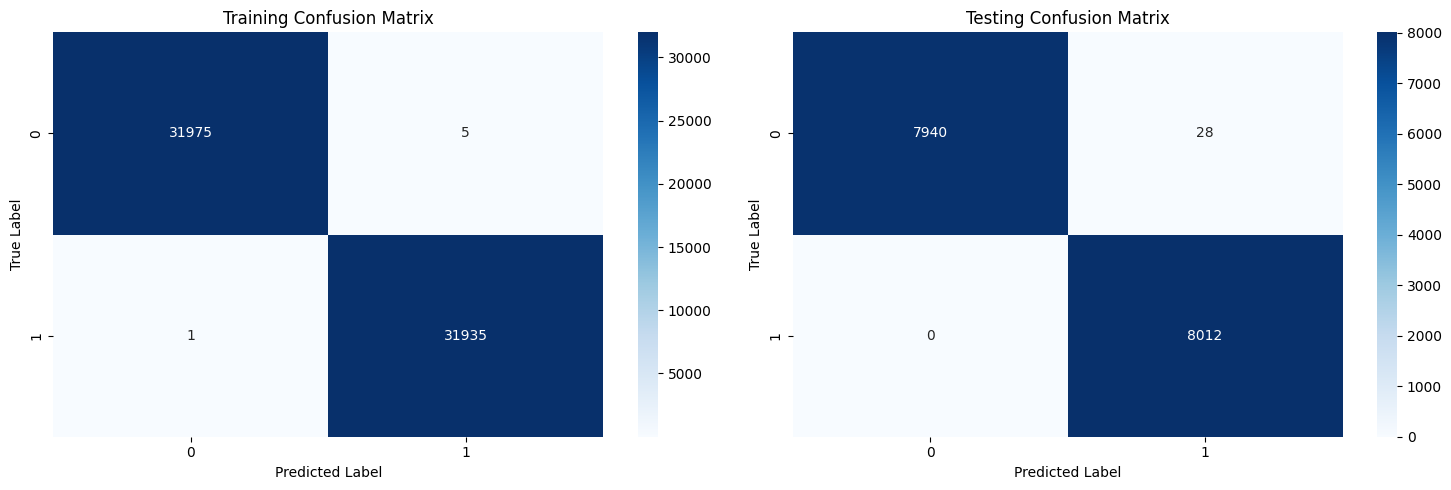

Algorithm: Random Forest
      Metric  Training  Testing
0  Precision     100.0     99.9
1     Recall     100.0     99.9
2   F1-score     100.0     99.9




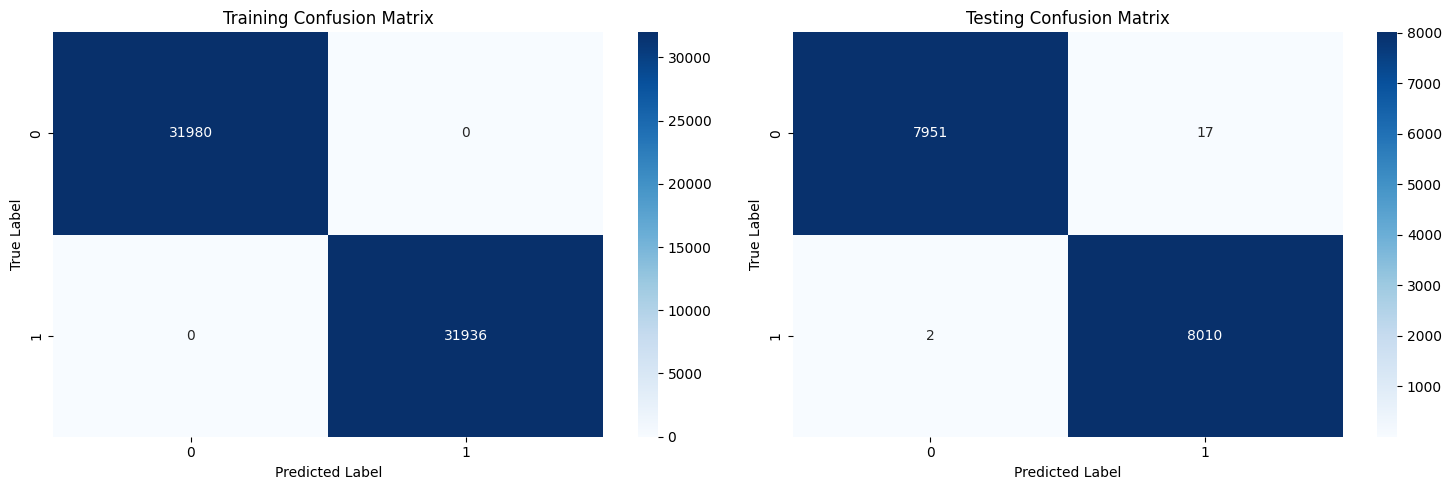

Algorithm: ExtraTreesClassifier
      Metric  Training  Testing
0  Precision     100.0     99.9
1     Recall     100.0     99.9
2   F1-score     100.0     99.9




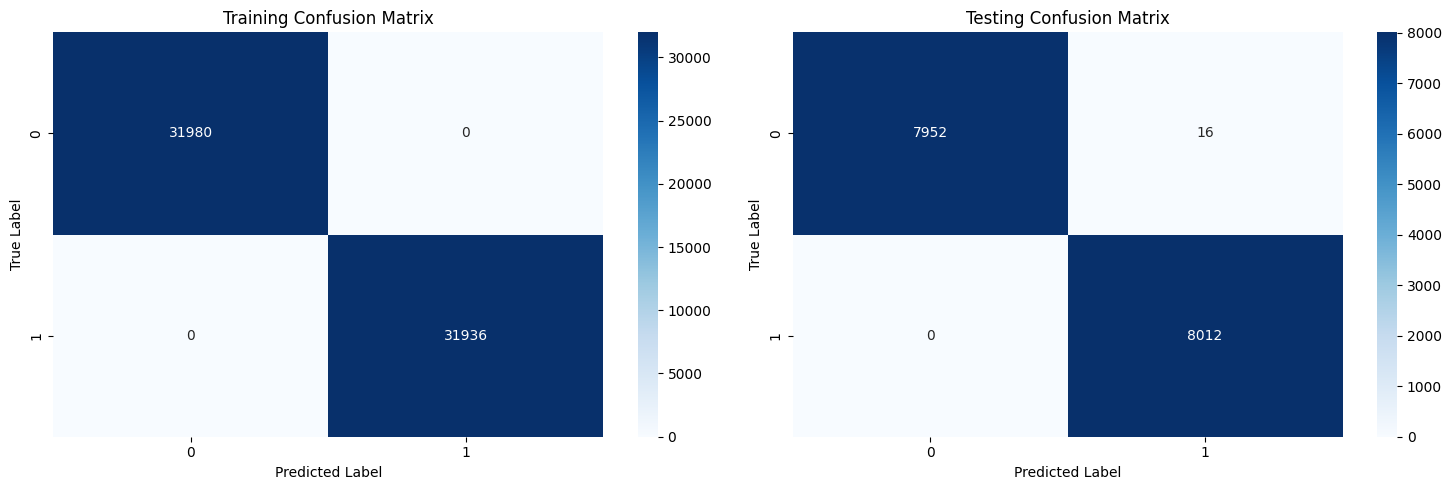

In [36]:
# Call fit_classification_models() function to generate results
results = fit_classification_models(X_train_os, y_train_os)

# Plot confusion matrices and display DataFrame for each algorithm
for classifier_name, metrics in results.items():
    print(f"Algorithm: {classifier_name}")

    # Display DataFrame
    df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-score'],
        'Training': [metrics['training']['precision'], metrics['training']['recall'], metrics['training']['f1-score']],
        'Testing': [metrics['testing']['precision'], metrics['testing']['recall'], metrics['testing']['f1-score']]
    })
    print(df)
    print("\n")

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Training confusion matrix
    sns.heatmap(metrics['training']['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Training Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Testing confusion matrix
    sns.heatmap(metrics['testing']['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title('Testing Confusion Matrix')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()


In [37]:
# Initialize a list to store the scores
all_scores = []

# Iterate over the results
for classifier_name, metrics in results.items():
    # Append the scores to the list
    all_scores.append({
        'Algorithm': classifier_name,
        'Training Precision': metrics['training']['precision'],
        'Testing Precision': metrics['testing']['precision'],
        'Training Recall': metrics['training']['recall'],
        'Testing Recall': metrics['testing']['recall'],
        'Training F1-score': metrics['training']['f1-score'],
        'Testing F1-score': metrics['testing']['f1-score']
    })

# Create a DataFrame from the scores list
scores_df = pd.DataFrame(all_scores)

# Sort the DataFrame by the 'Testing F1-score' column in descending order
scores_sorted = scores_df.sort_values(by='Testing F1-score', ascending=False)

# Display the sorted DataFrame
scores_sorted

,Algorithm,Training Precision,Testing Precision,Training Recall,Testing Recall,Training F1-score,Testing F1-score
1,Random Forest,100.0,99.9,100.0,99.9,100.0,99.9
2,ExtraTreesClassifier,100.0,99.9,100.0,99.9,100.0,99.9
0,XGBoost,100.0,99.8,100.0,99.8,100.0,99.8


## Choosing the XGBoost Model as our Final Model

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import joblib

# Assuming you have your data in X_train_os, y_train_os
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_os, y_train_os, test_size=0.2, random_state=42)

# Define and train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Evaluate the model using F1 score
train_f1 = f1_score(y_train, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)

print(f"Training F1-score: {train_f1}")
print(f"Testing F1-score: {test_f1}")


Training F1-score: 0.9999373767103986
Testing F1-score: 0.9984420764005734


## Saving the Model in Joblib and Pickle format

In [39]:
import pickle
import joblib

# Save the trained model using joblib
joblib.dump(xgb_model, 'aml_model.joblib')


# Save the trained model using pickle
with open('aml_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

## Load the pickle model

In [40]:
import pickle

# Load the trained model using pickle
with open('aml_model.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

## Make Predictions on the Pickle model

In [41]:
# Make predictions using the loaded model from pickle
predictions_pickle = loaded_model_pickle.predict(X_test)

In [42]:
print(predictions_pickle[:50])

[0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1
 1 1 1 1 0 0 0 0 1 0 1 1 0]


## Load the Joblib model

In [43]:
import joblib

# Load the trained model using joblib
loaded_model_joblib = joblib.load('aml_model.joblib')

## Make predictions on the joblib model

In [44]:
# Make predictions using the loaded model from joblib
predictions_joblib = loaded_model_joblib.predict(X_test)

In [45]:
print(predictions_joblib[:50])

[0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1
 1 1 1 1 0 0 0 0 1 0 1 1 0]
